In [129]:
import cv2
from matplotlib import pyplot as plt
from imutils import face_utils
import numpy as np
import argparse
import scipy
from PIL import Image

In [3]:
#import dlib

The two main loops in the affine warp part for 50 images take 17-18 minutes, and the blend is done instantly.

# Importing the images

In [132]:
head1 = cv2.imread('yusufhan_1.jpg')
head1 = cv2.cvtColor(head1, cv2.COLOR_BGR2RGB)
head2 = cv2.imread('yusufhan2.jpg')
head2 = cv2.cvtColor(head2, cv2.COLOR_BGR2RGB)

head1 = head1[50:550, 50:550]

print(head1.shape)
print(head2.shape)

(500, 500, 3)
(500, 500, 3)


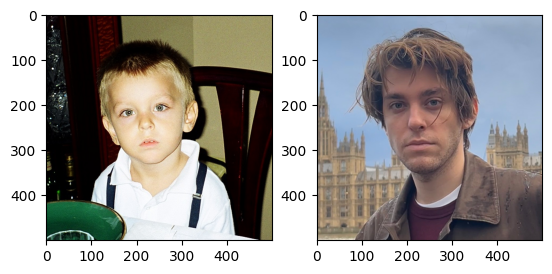

In [133]:
plt.subplot(1, 2, 1)
plt.imshow(head1)
plt.subplot(1, 2, 2)
plt.imshow(head2)

# Landmark Detection

### Landmark Detection with Dlib

In [149]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [ ]:
_, landmarks_head1 = get_landmarks(head1)
lndmrk1 = np.array(landmarks_head1)

_, landmarks_head2 = get_landmarks(head2)
lndmrk2 = np.array(landmarks_head2)

In [18]:
def get_corner(image):
  corner_points = [
      (0, 0),
      (image.shape[1] - 1, 0),
      (image.shape[1] - 1, image.shape[0] - 1),
      (0, image.shape[0] - 1)
  ]
  return corner_points


def get_edge_centers(image):
    height, width = image.shape[:2]
    top_center = (width / 2, 0)
    bottom_center = (width / 2, height-1)
    left_center = (0, height / 2)
    right_center = (width-1, height / 2)
    return np.array([top_center, bottom_center, left_center, right_center])


In [23]:
lndmrk1 = np.vstack([lndmrk1, get_corner(head1)])
lndmrk2 = np.vstack([lndmrk2, get_corner(head2)])

In [199]:
edge_centers1 = get_edge_centers(head1)
edge_centers2 = get_edge_centers(head2)

lndmrk1 = np.vstack([lndmrk1, edge_centers1])
lndmrk2 = np.vstack([lndmrk2, edge_centers2])

In [202]:
lndmrk1 = np.vstack([lndmrk1, [150,160]])
lndmrk1 = np.vstack([lndmrk1, [180,140]])
lndmrk1 = np.vstack([lndmrk1, [210,140]])
lndmrk1 = np.vstack([lndmrk1, [240,140]])
lndmrk1 = np.vstack([lndmrk1, [260,120]])

lndmrk2 = np.vstack([lndmrk2, [150,130]])
lndmrk2 = np.vstack([lndmrk2, [180,110]])
lndmrk2 = np.vstack([lndmrk2, [210,110]])
lndmrk2 = np.vstack([lndmrk2, [240,110]])
lndmrk2 = np.vstack([lndmrk2, [280,130]])

In [208]:
#np.save('lndmrk1.npy', lndmrk1)
#np.save('lndmrk2.npy', lndmrk2)

### Landmark Loading

In [203]:
def get_landmarks(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces_in_image = detector(img_gray, 0)
    face = faces_in_image[0] #Using only one face

    landmarks = predictor(img_gray, face)

    landmarks_list = []
    for i in range(0, landmarks.num_parts):
        landmarks_list.append([landmarks.part(i).x, landmarks.part(i).y])

    return face, landmarks_list

def plot_landmarks_side_by_side(image1, landmarks1, image2, landmarks2):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot for the first image
    axes[0].imshow(image1)
    x1 = [landmark[0] for landmark in landmarks1]
    y1 = [landmark[1] for landmark in landmarks1]
    axes[0].scatter(x1, y1, c='r', s=5)
    axes[0].set_title('Head Image 1')

    # Plot for the second image
    axes[1].imshow(image2)
    x2 = [landmark[0] for landmark in landmarks2]
    y2 = [landmark[1] for landmark in landmarks2]
    axes[1].scatter(x2, y2, c='r', s=5)
    axes[1].set_title('Head Image 2')

    plt.show()

In [197]:
lndmrk1 = np.load('lndmrk1.npy')
lndmrk2 = np.load('lndmrk2.npy')

In [200]:
lndmrk1.shape

(76, 2)

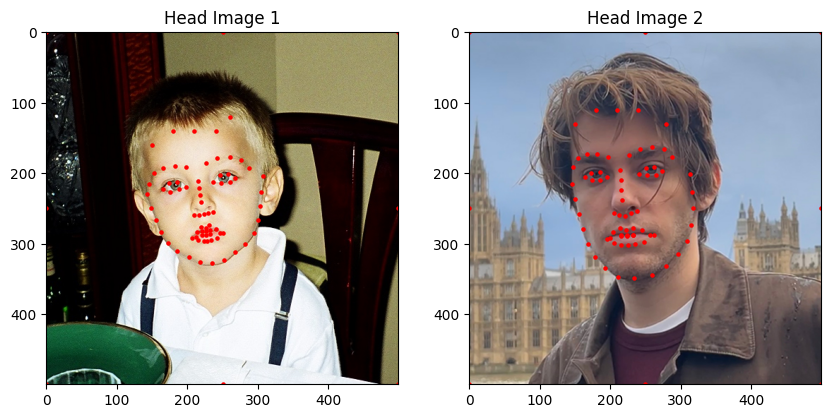

In [204]:
plot_landmarks_side_by_side(head1, lndmrk1, head2, lndmrk2)

# Triangulation

In [205]:
def plot_delaunay(image1, landmarks_head1, tri1, image2, landmarks_head2, tri2):

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

    point_size = 1.5
    line_width = 0.5
    line_color = "black"

    # Plot triangulation for the first image
    axes[0].imshow(image1)
    axes[0].triplot(landmarks_head1[:, 0], landmarks_head1[:, 1], tri1, color=line_color, linewidth=line_width)
    axes[0].plot(landmarks_head1[:, 0], landmarks_head1[:, 1], 'o', color='red',markersize=point_size)
    axes[0].set_title('Triangulation Image 1')

    # Plot triangulation for the second image
    axes[1].imshow(image2)
    axes[1].triplot(landmarks_head2[:, 0], landmarks_head2[:, 1], tri2, color=line_color,linewidth=line_width)
    axes[1].plot(landmarks_head2[:, 0], landmarks_head2[:, 1], 'o', color='red',markersize=point_size)
    axes[1].set_title('Triangulation Image 2')

    plt.show()

In [206]:
tr1 = scipy.spatial.Delaunay(lndmrk1).simplices
tri_list = tr1
print("Number of triangles for head1:",tr1.shape)

Number of triangles for head1: (152, 3)


#### In case of need to use of 2 different Delaunay Triangulation


This was not used in the end, I was considering using two different trinagulation of the landmarks, but I ended up using a single triangulation.

In [342]:
tr1 = scipy.spatial.Delaunay(lndmrk1).simplices
tr2 = scipy.spatial.Delaunay(lndmrk2).simplices

print("Number of triangles for head1:",tr1.shape)
print("Number of triangles for head2:",tr2.shape)

Number of triangles for head1: (142, 3)
Number of triangles for head2: (140, 3)


In [694]:
import operator
tr1 = sorted(tr1, key = operator.itemgetter(0,1,2))
tr2 = sorted(tr2, key = operator.itemgetter(0,1,2))
tr1 = np.array(tr1)
tr2 = np.array(tr2)

### Triangle Visualization

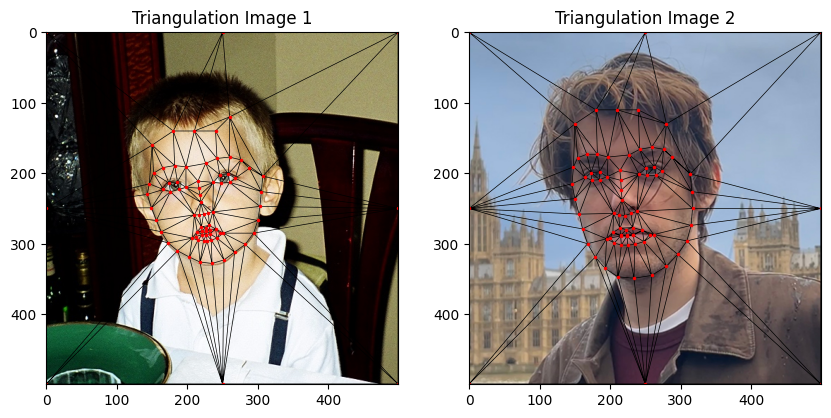

In [207]:
plot_delaunay(head1, lndmrk1, tr1, head2, lndmrk2, tr1)

# Intermediate Image Coordinates for "*in between*" images

Create the intermediate image coordinates in all “in between” images for all the **vertices of all triangles**

In [209]:
def get_inbetween_cords(lndmrk1,lndmrk2, NUM_IMAGES):

    #Interpolating between two set of landmark coordinates, creating the in between landmark coordinates 

    int_points = []
    #Going over each in between frame
    for j in range(0, NUM_IMAGES):

        intermediate_points = []
        alpha = j/(NUM_IMAGES-1)
        
        #Going over each lndmrk coordinate
        for i in range(0, len(lndmrk1)):

            #Calculating the x and y values by using the step size 
            x = (1 - alpha) * lndmrk1[i][0] + alpha * lndmrk2[i][0]
            y = (1 - alpha) * lndmrk1[i][1] + alpha * lndmrk2[i][1]

            intermediate_points.append((x,y))

        int_points.append(intermediate_points)

    intermidiate_points = np.array(int_points)
    return intermidiate_points

In [62]:
test_inbetween = get_inbetween_cords(lndmrk1, lndmrk2, 4)
test_inbetween.shape

(4, 80, 2)

# Affine Warp Estimation using Triangles

In [210]:
def estimate_affine_transform(src_triangle, dst_triangle):

    ones = np.ones((3,1))

    #Converting the source and destination triangles into homogenous coordinates by appending 1 as a new column
    src_homogeneous =  np.hstack([src_triangle,ones])
    out_homogenous = np.hstack([dst_triangle,ones])

    #I do transpose because I need 3x1 not 1x3
    #Calculating the affine matrix  Y  = A X
    # Y inv(X) =  A X inv(X)
    # Y inv(X) = A
    affine_tri =np.float32(np.dot(out_homogenous.T, np.linalg.pinv(src_homogeneous.T)))

    #Sanity check, to compare values, they are the same
    #warpMat = cv2.getAffineTransform(np.float32(src_triangle), np.float32(dst_triangle))

    return affine_tri

### Test for affine estimation

In [17]:
first_img = test_inbetween[0]
second_img = test_inbetween[1]

aff_trans = []

for i in range(len(tri_list)):

    ins = first_img[tri_list[i]]
    out = second_img[tri_list[i]]

    affine = estimate_affine_transform(ins, out)
    aff_trans.append(affine)

test_aff_trans = np.array(aff_trans)
test_aff_trans.shape

(142, 3, 3)

# Mapping points between Triangles

In [212]:
def is_inside_triangle(pt, triangle):
    
    # Initially used the cv2.PointPolygon, had some errors with my output. For some reason it is causing some deadspots, black lines in the output. 
    # So I switched to a custom implemenetation
    # This is not a algorithm I came up with, since it is basically cv2.PointPolygon I thought I was allowed to use it 
    # I have found this algorithm which gave me better results
    # https://stackoverflow.com/questions/20248076/how-do-i-check-if-a-point-is-inside-a-triangle-on-the-line-is-ok-too
    # https://nerdparadise.com/math/pointinatriangle#:~:text=Cross%20Product%20Refresher&text=If%20AP%20%C3%97%20AB%2C%20BP,P%20is%20inside%20triangle%20ABC.

    #the sign function os used to determine the orinetation of the triangle
    #Using the tpositions of the point given and triangle coordinates
    #If the result is negative, it implies that the point lies on one side of the edge; if positive, on the other side.
    # It take sthe cross product of the three points
    def sign(p1, p2, p3):
        return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])

    #Determining the point position relative to the trinagle edges
    #These lines determine the position of the point pt relative to each edge of the triangle. 
    #The sign function is called with the point and two vertices of the triangle that form an edge. 
    #b1 is used to check if point is on a specific side of the edge formed by triangle[0] and triangle[1]
    b1 = sign(pt, triangle[0], triangle[1]) < 0.0
    b2 = sign(pt, triangle[1], triangle[2]) < 0.0
    b3 = sign(pt, triangle[2], triangle[0]) < 0.0

    # All of the points are in the same side of all three edges, then its is true
    #
    return ((b1 == b2) and (b2 == b3))

In [213]:
def bilinear_interpolate(img, x, y):
    
    #Finding ththe coordinates of the top left corner of the nearest pixel, this is the top left because int() rounds to 0
    x0 = int(x)
    y0 = int(y)

    #Calculating the coordinates of the bottom right corner of the cell
    x1 = x0 + 1 
    y1 = y0 + 1

    #Checking if the created coordinates are in the boundaries of the image.
    #Clipping the values making sure they are in the range of image dimensions, x min max
    x0 = np.clip(x0, 0, img.shape[1] - 1)
    x1 = np.clip(x1, 0, img.shape[1] - 1)
    y0 = np.clip(y0, 0, img.shape[0] - 1)
    y1 = np.clip(y1, 0, img.shape[0] - 1)

    #x0y0 top left
    #x1y0 top right
    #x0y1 bot left
    #x1y1 bot right
    
    #Getting pixel values from the source/destination image using the int coordinates
    #Pixel values at of corners of the pixel cells
    #Opencv img(row, column img3[cY,cX])
    Ia = img[y0, x0]
    Ib = img[y1, x0]
    Ic = img[y0, x1]
    Id = img[y1, x1]
    
    #Now weights are created with respect to the original given coordinates(which are not int)
    #Calculating the weights, based on distances of x and y from the corners
    #Reverse relation between the distance values and the weights, so choosing the reverse corners distance values
    wa = (x1 - x) * (y1 - y)
    wb = (x1 - x) * (y - y0)
    
    wc = (x - x0) * (y1 - y)
    wd = (x - x0) * (y - y0)
    
    #Reverse weights
    #Using the weights, taking a weighted average of the values with respect to the their positions to the given point
    return wa * Ia + wb * Ib + wc * Ic + wd * Id

In [229]:
num_images = 100
inbetween_cords = get_inbetween_cords(lndmrk1,lndmrk2, num_images)

print(inbetween_cords.shape)
print(tri_list.shape)

(100, 81, 2)
(152, 3)


### Warping Points One by One (Not-Vectorized)

In [67]:
output_images = []
normalized = []

head1 = np.float32(head1)
head2 = np.float32(head2)

#Looping through each step forwards to from source to destination image
for step in range(0, num_images): #Going forwards.
    print(step, end=' ')
    
    #current_inbetween_images_landmark coordinates
    #Getting inbetween landmarks for the current step
    current_inbetween_cord = inbetween_cords[step]
    
    #next_inbetween_images_landmark coordinates

    #At first, I tried to do the implementation by calculating the affine transformation with respect to the next index
    #next_inbetween_cord = inbetween_cords[step + 1]
    #Implemented in a sliding window type of algorithm where each triangles transformation to the destination is calculated by with respect to the next index
    #However I had a lot of trouble making it work like that, after making it work, it was a just giving me slighlty blurry results compared to my current implementation.
    
    next_inbetween_cord = lndmrk2
    # Then, I then went with a different approach where I would be calculating my affine transformation matrixes using the destination images.
    # So in each iteration the transformation matrix, is calculated with respect to the destination landmarks
    # Therefore at the begining in between images gets significant transformation matrixes, and towards the end they get lesser values for the transformation.
    # This causes the first 25 inbetween coordinates to be transformed a lot compared to the last 25 inbetween coordinates.
    # So when the loop ends after interpolating the values for each triangle, I must reverse the list since for slow transition.
    # I want the inbetween images with lesser transformations at the begining, (since i am interpolating with source image values)
    # And I want the inbetween images with significant transformations towards the end. That is why I must reverse the list I create


    morphed_frame = np.zeros(head1.shape, dtype = head1.dtype)

    for i in range(len(tri_list)):

        #tri_list[i] is the current triangles indexes

        #One of the current intermidiate steps', triangle
        current_t = np.float32(current_inbetween_cord[tri_list[i]])

        #Current Destination, triangle
        next_t = np.float32(next_inbetween_cord[tri_list[i]])
            
        #Affine matrix for the current triangle
        affine_matrix_for_current_tri = estimate_affine_transform(current_t, next_t)
        #Since backward mapping, I must do an inverse
        inverse_affine_matrix = np.linalg.pinv(affine_matrix_for_current_tri)[:2,:] # Extracting the necessary rows

        #Creating a bounding rectangle in order to traverse the destination triangles coordinates
        r2 = cv2.boundingRect(np.float32([next_t]))

        r2 = (
            max(r2[0], 0),# top left x
            max(r2[1], 0), # top left y
            min(r2[2], head1.shape[1]),# bot right x, head[1] cols, which is x
            min(r2[3], head1.shape[0]), # bot right y head[o] rows ,which is y
        )


        #Going over each coordinate of the destination rectangle
        for x in range(r2[0], r2[0] + r2[2]):
            for y in range(r2[1], r2[1] + r2[3]):
                #If the coordinate is inside the triangle then, the transformation will be made
                if is_inside_triangle((x, y), next_t):
                #if cv2.pointPolygonTest(next_t, (x, y), False):
                    
                    #pt = np.dot(inverse_affine_matrix, np.array([x, y, 1]))
                    #Calculating the inverse transformation for the current triangle
                    pt = inverse_affine_matrix @ np.array([x, y, 1])

                    #Extracting values
                    srcX, srcY = pt[0], pt[1]
                    
                    #shape[1] width x dimension, shape[0] height ydimension
                    #Boundary check to ensure that srcX and srcY are within the range of head1.shape
                    if (0 <= srcX < head1.shape[1]) and (0 <= srcY < head1.shape[0] ):
                        ## Interpolating the color value from the source image
                        
                        #Doing the bilinear interpolation with respect to head1
                        color1 = bilinear_interpolate(head1, srcX, srcY)

                        #Initially thought I would be doing the blending here
                        #color2 = bilinear_interpolate(head2, srcX, srcY)
                        #morphed_frame[y, x] = color1
                        #morphed_frame[y, x] = (color1 * (1-w) + color2 * w)

                        morphed_frame[y, x] = color1

    output_images.append(morphed_frame)
    

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

In [ ]:
second_output_images = []
normalized = []

head1 = np.float32(head1)
head2 = np.float32(head2)


#The same structure, same loop, same variables as the below cell
#Only difference is that for this loop, the program goes from the destination image(head2) to source image(head1)
#So instead of using landmarks for the destionation image, landmarks for the source image is used

for step in range(num_images - 1, -1, -1): # Going backwards.
    print(step, end=' ')
    w = step / (num_images - 1)
    #current_inbetween_images_landmark coordinates
    current_inbetween_cord = inbetween_cords[step]

    #next_inbetween_images_landmark coordinates
    #next_inbetween_cord = inbetween_cords[step - 1]
    next_inbetween_cord = lndmrk1

    morphed_frame = np.zeros(head1.shape, dtype = head1.dtype)

    for i in range(len(tri_list)):

        #tri_list[i] is the current triangles indexes

        #One of the current intermidiate steps', triangle
        current_t = np.float32(current_inbetween_cord[tri_list[i]])

        #One of the next intermidiate steps', triangle
        next_t = np.float32(next_inbetween_cord[tri_list[i]])
            
        #Affine matrix for the current triangle
        affine_matrix_for_current_tri = estimate_affine_transform(current_t, next_t)
        inverse_affine_matrix = np.linalg.pinv(affine_matrix_for_current_tri)[:2,:] # Extracting the necessary rows

        r2 = cv2.boundingRect(np.float32([next_t]))

        r2 = (
            max(r2[0], 0),
            max(r2[1], 0),
            min(r2[2], head2.shape[1]),
            min(r2[3], head2.shape[0]),
        )

        for x in range(r2[0], r2[0] + r2[2]):
            for y in range(r2[1], r2[1] + r2[3]):

                if is_inside_triangle((x, y), next_t):
                #if cv2.pointPolygonTest(next_t, (x, y), False):

                    #pt = np.dot(inverse_affine_matrix, np.array([x, y, 1]))
                    pt = inverse_affine_matrix @ np.array([x, y, 1])

                    srcX, srcY = pt[0], pt[1]

                    #Boundary check to ensure that srcX and srcY are within the range of head1.shape
                    if (0 <= srcX < head2.shape[1]) and (0 <= srcY < head2.shape[0] ):
                        ## Interpolating the color value from the source image
                        
                        #Bilinear interpolation using head2 values
                        color1 = bilinear_interpolate(head2, srcX, srcY)
                        #color2 = bilinear_interpolate(head2, srcX, srcY)

                        #morphed_frame[y, x] = color1
                        #morphed_frame[y, x] = (color1 * (1-w) + color2 * w)

                        morphed_frame[y, x] = color1

    second_output_images.append(morphed_frame)


### Vectorized Triangle Warp

In [230]:
from matplotlib.path import Path

def is_inside_triangle_vectorized(points, triangle):
    # Create a path from the triangle vertices
    path = Path(triangle)
    # Check if the points are inside the triangle
    return path.contains_points(points)

In [231]:
def vectorized_bilinear_interpolate(img, x, y):
    x0 = np.floor(x).astype(int)
    x1 = x0 + 1
    y0 = np.floor(y).astype(int)
    y1 = y0 + 1

    x0 = np.clip(x0, 0, img.shape[1] - 1)
    x1 = np.clip(x1, 0, img.shape[1] - 1)
    y0 = np.clip(y0, 0, img.shape[0] - 1)
    y1 = np.clip(y1, 0, img.shape[0] - 1)

    Ia = img[y0, x0]
    Ib = img[y1, x0]
    Ic = img[y0, x1]
    Id = img[y1, x1]

    wa = (x1 - x) * (y1 - y)
    wb = (x1 - x) * (y - y0)
    wc = (x - x0) * (y1 - y)
    wd = (x - x0) * (y - y0)

    return wa[..., np.newaxis] * Ia + wb[..., np.newaxis] * Ib + wc[..., np.newaxis] * Ic + wd[..., np.newaxis] * Id


In [232]:
output_images = []
normalized = []

head1 = np.float32(head1)
head2 = np.float32(head2)

#Looping through each step forwards to from source to destination image
for step in range(0, num_images): #Going forwards.
    print(step, end=' ')
    
    #current_inbetween_images_landmark coordinates
    #Getting inbetween landmarks for the current step
    current_inbetween_cord = inbetween_cords[step]
    
    #next_inbetween_images_landmark coordinates

    #At first, I tried to do the implementation by calculating the affine transformation with respect to the next index
    #next_inbetween_cord = inbetween_cords[step + 1]
    #Implemented in a sliding window type of algorithm where each triangles transformation to the destination is calculated by with respect to the next index
    #However I had a lot of trouble making it work like that, after making it work, it was a just giving me slighlty blurry results compared to my current implementation.
    
    next_inbetween_cord = lndmrk2
    # Then, I then went with a different approach where I would be calculating my affine transformation matrixes using the destination images.
    # So in each iteration the transformation matrix, is calculated with respect to the destination landmarks
    # Therefore at the begining in between images gets significant transformation matrixes, and towards the end they get lesser values for the transformation.
    # This causes the first 25 inbetween coordinates to be transformed a lot compared to the last 25 inbetween coordinates.
    # So when the loop ends after interpolating the values for each triangle, I must reverse the list since for slow transition.
    # I want the inbetween images with lesser transformations at the begining, (since i am interpolating with source image values)
    # And I want the inbetween images with significant transformations towards the end. That is why I must reverse the list I create


    morphed_frame = np.zeros(head1.shape, dtype = head1.dtype)

    for i in range(len(tri_list)):

        #tri_list[i] is the current triangles indexes

        #One of the current intermidiate steps', triangle
        current_t = np.float32(current_inbetween_cord[tri_list[i]])

        #Current Destination, triangle
        next_t = np.float32(next_inbetween_cord[tri_list[i]])
            
        #Affine matrix for the current triangle
        affine_matrix_for_current_tri = estimate_affine_transform(current_t, next_t)
        #Since backward mapping, I must do an inverse
        inverse_affine_matrix = np.linalg.pinv(affine_matrix_for_current_tri)[:2,:] # Extracting the necessary rows

        #Creating a bounding rectangle in order to traverse the destination triangles coordinates
        r2 = cv2.boundingRect(np.float32([next_t]))

        r2 = (
            max(r2[0], 0),# top left x
            max(r2[1], 0), # top left y
            min(r2[2], head1.shape[1]),# bot right x, head[1] cols, which is x
            min(r2[3], head1.shape[0]), # bot right y head[o] rows ,which is y
        )
        
        # Generate grid of coordinates
        x, y = np.meshgrid(range(r2[0], r2[0] + r2[2]), range(r2[1], r2[1] + r2[3]))

        # Flatten the grids and add a row of ones for homogeneous coordinates
        ones = np.ones(x.shape)
        grid = np.vstack([x.flatten(), y.flatten(), ones.flatten()])

        # Apply the inverse affine transformation
        transformed_grid = inverse_affine_matrix @ grid

        # Extract the transformed coordinates
        srcX, srcY = transformed_grid[0, :], transformed_grid[1, :]

        # Perform boundary checks
        valid_indices = (srcX >= 0) & (srcX < head1.shape[1]) & (srcY >= 0) & (srcY < head1.shape[0])

        # Filter out valid coordinates
        valid_srcX = srcX[valid_indices]
        valid_srcY = srcY[valid_indices]
        valid_x = x.flatten()[valid_indices]
        valid_y = y.flatten()[valid_indices]

        points = np.column_stack([valid_x, valid_y])
        inside_triangle = is_inside_triangle_vectorized(points, next_t)

        # Filter out the points that are inside the triangle
        final_valid_x = valid_x[inside_triangle]
        final_valid_y = valid_y[inside_triangle]
        final_valid_srcX = valid_srcX[inside_triangle]
        final_valid_srcY = valid_srcY[inside_triangle]

        # Vectorized bilinear interpolation for the points inside the triangle
        color1 = vectorized_bilinear_interpolate(head1, final_valid_srcX, final_valid_srcY)

        # Assign the interpolated colors back to the morphed frame
        morphed_frame[final_valid_y, final_valid_x] = color1.reshape(-1, 3)

        
    output_images.append(morphed_frame)
    

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [233]:
second_output_images = []
normalized = []

head1 = np.float32(head1)
head2 = np.float32(head2)


#The same structure, same loop, same variables as the below cell
#Only difference is that for this loop, the program goes from the destination image(head2) to source image(head1)
#So instead of using landmarks for the destionation image, landmarks for the source image is used

for step in range(num_images - 1, -1, -1): # Going backwards.
    print(step, end=' ')
    w = step / (num_images - 1)
    #current_inbetween_images_landmark coordinates
    current_inbetween_cord = inbetween_cords[step]

    #next_inbetween_images_landmark coordinates
    #next_inbetween_cord = inbetween_cords[step - 1]
    next_inbetween_cord = lndmrk1

    morphed_frame = np.zeros(head1.shape, dtype = head1.dtype)

    for i in range(len(tri_list)):

        #tri_list[i] is the current triangles indexes

        #One of the current intermidiate steps', triangle
        current_t = np.float32(current_inbetween_cord[tri_list[i]])

        #One of the next intermidiate steps', triangle
        next_t = np.float32(next_inbetween_cord[tri_list[i]])
            
        #Affine matrix for the current triangle
        affine_matrix_for_current_tri = estimate_affine_transform(current_t, next_t)
        inverse_affine_matrix = np.linalg.pinv(affine_matrix_for_current_tri)[:2,:] # Extracting the necessary rows

        r2 = cv2.boundingRect(np.float32([next_t]))

        r2 = (
            max(r2[0], 0),# top left x
            max(r2[1], 0), # top left y
            min(r2[2], head1.shape[1]),# bot right x, head[1] cols, which is x
            min(r2[3], head1.shape[0]), # bot right y head[o] rows ,which is y
        )
        
        # Generate grid of coordinates
        x, y = np.meshgrid(range(r2[0], r2[0] + r2[2]), range(r2[1], r2[1] + r2[3]))

        # Flatten the grids and add a row of ones for homogeneous coordinates
        ones = np.ones(x.shape)
        grid = np.vstack([x.flatten(), y.flatten(), ones.flatten()])

        # Apply the inverse affine transformation
        transformed_grid = inverse_affine_matrix @ grid

        # Extract the transformed coordinates
        srcX, srcY = transformed_grid[0, :], transformed_grid[1, :]

        # Perform boundary checks
        valid_indices = (srcX >= 0) & (srcX < head1.shape[1]) & (srcY >= 0) & (srcY < head1.shape[0])

        # Filter out valid coordinates
        valid_srcX = srcX[valid_indices]
        valid_srcY = srcY[valid_indices]
        valid_x = x.flatten()[valid_indices]
        valid_y = y.flatten()[valid_indices]

        points = np.column_stack([valid_x, valid_y])
        inside_triangle = is_inside_triangle_vectorized(points, next_t)

        # Filter out the points that are inside the triangle
        final_valid_x = valid_x[inside_triangle]
        final_valid_y = valid_y[inside_triangle]
        final_valid_srcX = valid_srcX[inside_triangle]
        final_valid_srcY = valid_srcY[inside_triangle]

        # Vectorized bilinear interpolation for the points inside the triangle
        color1 = vectorized_bilinear_interpolate(head2, final_valid_srcX, final_valid_srcY)

        # Assign the interpolated colors back to the morphed frame
        morphed_frame[final_valid_y, final_valid_x] = color1.reshape(-1, 3)


    second_output_images.append(morphed_frame)

99 98 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 76 75 74 73 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 51 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 0 

# Blending Images

In [234]:
output_images = np.array(output_images)
second_output_images = np.array(second_output_images)

#Reversing it so it gives the images from source
#Explained this part in the first loop.
#Reversing the output from the first loop, to get the appropriate values for the morphing

output_images_reversed = np.array(output_images)[::-1]

blended_images = []
blended_images.append(head1) 

num_images = len(output_images)

for i in range(num_images):
    
    w = i / (num_images - 1)  # Linear weight change

    #I was getting a overflow from this part therefore I am dividing by 255 to add to values up together
    img1 = output_images_reversed[i].astype(np.float32) / 255
    img2 = second_output_images[i].astype(np.float32) / 255

    #Bledning with weights for each step
    blended_image = (1-w) * img1 + (w)* img2
    blended_image = (blended_image * 255).astype(np.uint8)
    blended_images.append(blended_image)

blended_images.append(head2)


### View output Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


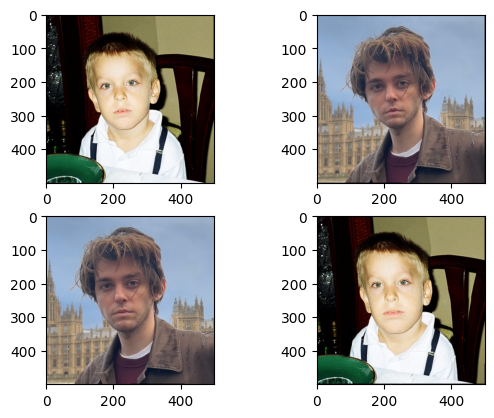

In [240]:
plt.subplot(2, 2, 1)
plt.imshow(output_images[48]/255)
plt.subplot(2, 2, 2)
plt.imshow(second_output_images[25]/255)
plt.subplot(2, 2, 3)
plt.imshow(second_output_images[60]/255)
plt.subplot(2, 2, 4)
plt.imshow(output_images[10]/255)

# Output Image to Video Conversion

In [241]:
import os
os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/bin/ffmpeg"

In [244]:
height, width, c = second_output_images[0].shape

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('output0.mp4', fourcc, 30, (width, height))

for img in second_output_images:

    #Normalizing it
    img_uint8 = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')    
    img_bgr = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)

    out.write(img_bgr)

out.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [252]:
blended_images_reversed = np.array(blended_images)[::-1]
blendlist = np.concatenate((blended_images, blended_images_reversed))

In [256]:
height, width, c = blended_images[0].shape

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('output1.mp4', fourcc, 40, (width, height))

for img in blended_images:

    #Normalizing it
    img_uint8 = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')    
    img_bgr = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)

    out.write(img_bgr)

out.release()


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [255]:
height, width, c = blendlist[0].shape

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('output2.mp4', fourcc, 30, (width, height))

for img in blendlist:

    #Normalizing it
    img_uint8 = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')    
    img_bgr = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)

    out.write(img_bgr)

out.release()


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


# My initial Approach for the Affine Warp - Kept this for Notes - DON'T RUN

In [61]:
output_images = []
normalized = []

head1 = np.float32(head1)
head2 = np.float32(head2)

for step in range(0, num_images-1): #Going forwards.
    print(step, end=' ')
    
    w = step / (num_images - 1)

    #current_inbetween_images_landmark coordinates
    current_inbetween_cord = inbetween_cords[step]
    next_inbetween_cord = inbetween_cords[step + 1]

    #next_inbetween_images_landmark coordinates
    #next_inbetween_cord = lndmrk2

    morphed_frame = np.zeros(head1.shape, dtype = head1.dtype)

    for i in range(len(tri_list)):

        #tri_list[i] is the current triangles indexes

        #One of the current intermidiate steps', triangle
        current_t = np.float32(current_inbetween_cord[tri_list[i]])

        #One of the next intermidiate steps', triangle
        next_t = np.float32(next_inbetween_cord[tri_list[i]])
            
        #Affine matrix for the current triangle
        affine_matrix_for_current_tri = estimate_affine_transform(current_t, next_t)
        inverse_affine_matrix = np.linalg.pinv(affine_matrix_for_current_tri)[:2,:] # Extracting the necessary rows

        r2 = cv2.boundingRect(np.float32([next_t]))

        r2 = (
            max(r2[0], 0),
            max(r2[1], 0),
            min(r2[2], head1.shape[1]),
            min(r2[3], head1.shape[0]),
        )

        for x in range(r2[0], r2[0] + r2[2]):
            for y in range(r2[1], r2[1] + r2[3]):

                if is_inside_triangle((x, y), next_t):
                #if cv2.pointPolygonTest(next_t, (x, y), False):
                    
                    #pt = np.dot(inverse_affine_matrix, np.array([x, y, 1]))
                    pt = inverse_affine_matrix @ np.array([x, y, 1])

                    srcX, srcY = pt[0], pt[1]

                    #Boundary check to ensure that srcX and srcY are within the range of head1.shape
                    if (0 <= srcX < head1.shape[1]) and (0 <= srcY < head1.shape[0] ):
                        #if is_inside_triangle((srcX, srcY), current_t):
                        ## Interpolating the color value from the source image
                        
                        if(step == 0):
                            color1 = bilinear_interpolate(head1, srcX, srcY)
                        else:
                            color1 = bilinear_interpolate(output_images[step -1], srcX, srcY)

                        #color2 = bilinear_interpolate(head2, srcX, srcY)

                        #morphed_frame[y, x] = color1
                        #morphed_frame[y, x] = (color1 * (1-w) + color2 * w)

                        morphed_frame[y, x] = color1

    output_images.append(morphed_frame)


"output_images = []\nnormalized = []\n\nhead1 = np.float32(head1)\nhead2 = np.float32(head2)\n\nfor step in range(0, num_images-1): #Going forwards.\n    print(step, end=' ')\n    \n    w = step / (num_images - 1)\n\n    #current_inbetween_images_landmark coordinates\n    current_inbetween_cord = inbetween_cords[step]\n    next_inbetween_cord = inbetween_cords[step + 1]\n\n    #next_inbetween_images_landmark coordinates\n    #next_inbetween_cord = lndmrk2\n\n    morphed_frame = np.zeros(head1.shape, dtype = head1.dtype)\n\n    for i in range(len(tri_list)):\n\n        #tri_list[i] is the current triangles indexes\n\n        #One of the current intermidiate steps', triangle\n        current_t = np.float32(current_inbetween_cord[tri_list[i]])\n\n        #One of the next intermidiate steps', triangle\n        next_t = np.float32(next_inbetween_cord[tri_list[i]])\n            \n        #Affine matrix for the current triangle\n        affine_matrix_for_current_tri = estimate_affine_transfor

In [ ]:

second_output_images = []
normalized = []

head1 = np.float32(head1)
head2 = np.float32(head2)

for step in range(num_images - 1, 0, -1): # Going backwards.
    print(step, end=' ')
    w = step / (num_images - 1)
    #current_inbetween_images_landmark coordinates
    current_inbetween_cord = inbetween_cords[step]

    #next_inbetween_images_landmark coordinates
    next_inbetween_cord = inbetween_cords[step - 1]
    #next_inbetween_cord = lndmrk1

    morphed_frame = np.zeros(head1.shape, dtype = head1.dtype)

    for i in range(len(tri_list)):

        #tri_list[i] is the current triangles indexes

        #One of the current intermidiate steps', triangle
        current_t = np.float32(current_inbetween_cord[tri_list[i]])

        #One of the next intermidiate steps', triangle
        next_t = np.float32(next_inbetween_cord[tri_list[i]])
            
        #Affine matrix for the current triangle
        affine_matrix_for_current_tri = estimate_affine_transform(current_t, next_t)
        inverse_affine_matrix = np.linalg.pinv(affine_matrix_for_current_tri)[:2,:] # Extracting the necessary rows

        r2 = cv2.boundingRect(np.float32([next_t]))

        r2 = (
            max(r2[0], 0),
            max(r2[1], 0),
            min(r2[2], head2.shape[1]),
            min(r2[3], head2.shape[0]),
        )

        for x in range(r2[0], r2[0] + r2[2]):
            for y in range(r2[1], r2[1] + r2[3]):

                if is_inside_triangle((x, y), next_t):
                #if cv2.pointPolygonTest(next_t, (x, y), False):

                    #pt = np.dot(inverse_affine_matrix, np.array([x, y, 1]))
                    pt = inverse_affine_matrix @ np.array([x, y, 1])

                    srcX, srcY = pt[0], pt[1]

                    #Boundary check to ensure that srcX and srcY are within the range of head1.shape
                    if (0 <= srcX < head2.shape[1]) and (0 <= srcY < head2.shape[0] ):
                        #if is_inside_triangle((srcX, srcY), current_t):
                        ## Interpolating the color value from the source image
                        
                        #color1 = bilinear_interpolate(head2, srcX, srcY)
                        #color2 = bilinear_interpolate(head2, srcX, srcY)

                        if(step == num_images - 1):
                            color1 = bilinear_interpolate(head2, srcX, srcY)
                        else:
                            color1 = bilinear_interpolate(second_output_images[num_images - step - 2], srcX, srcY)

                        #morphed_frame[y, x] = color1
                        #morphed_frame[y, x] = (color1 * (1-w) + color2 * w)

                        morphed_frame[y, x] = color1

    second_output_images.append(morphed_frame)


In [ ]:

output_images = np.array(output_images)
second_output_images = np.array(second_output_images)

#Reversing it so it gives the images from source
#output_images_reversed = np.array(output_images)[::-1]

second_output_images_reversed = second_output_images[::-1]

blended_images = []

blended_images.append(head1)
num_images = len(output_images)

for i in range(num_images):
    
    w = i / (num_images - 1)  # Linear weight change

    #I was getting a overflow from this part therefore I am dividing by 255 to add to values up together
    img1 = output_images[i].astype(np.float32) / 255
    img2 = second_output_images_reversed[i].astype(np.float32) / 255

    blended_image = (1-w) * img1 + (w)* img2
    blended_image = (blended_image * 255).astype(np.uint8)
    blended_images.append(blended_image)

blended_images.append(head2)



#output_images = np.array(output_images)
#second_output_images = np.array(second_output_images)

#Reversing it so it gives the images from source
#second_output_images_reversed = second_output_images[::-1]

#blended_images = []

#blended_images.append(head2)
#num_images = len(output_images)

#for i in range(num_images):
    
#    w = i / (num_images - 1)  # Linear weight change

     ##I was getting a overflow from this part therefore I am dividing by 255 to add to values up together
#    img1 = output_images[i].astype(np.float32) / 255
#    img2 = second_output_images_reversed[i].astype(np.float32) / 255

#    blended_image = (w) * img1 + (1-w)* img2
#    blended_image = (blended_image * 255).astype(np.uint8)
#    blended_images.append(blended_image)

#blended_images.append(head1)

